In [1]:
import pandas as pd
import numpy as np

In [2]:
def splt_exp_strp(df, col, d):
    '''Splits location information up.'''
    df = df.loc[:, col].str.split(d, expand = True)
    for col in df.columns:
        df.loc[:, col] = df.loc[:, col].str.strip()
    return df

def rem_ind(df1, df2):
    '''Returns second df entered after removing index from first df'''
    d1_ind = df1.index
    return df2[~df2.index.isin(d1_ind)]

df = pd.read_excel(r'10_11_20.xlsx')
#Changing the original date format to pd date format.
df.loc[:, 'Date'] = pd.to_datetime(df.Date)
#Only dollar signs.
#df.loc[:, 'Total Compensation'].str[0].unique()
#Using regex to replace dollar sign and commas in Total Comp col.
df.loc[:, 'Total Compensation'] = df.loc[:, 'Total Compensation'].str.replace('[^\w\s]','')
df.loc[:, 'Total Compensation'] = df.loc[:, 'Total Compensation'].astype(float)
#Thousands and Millions are only multipliers.
# for c in ['Base', 'Stock', 'Bonus']:
#     print(df.loc[:, c].str[-1].unique())
#Multipliers and dicts to map to distinct compensation elements.
spec_cols = ['Base', 'Stock', 'Bonus']
to_replace = {'k': 1000, 'M': 1000000, np.nan: np.nan}
cols_to_fix = {col: df.loc[:, col].str[-1].map(to_replace) for (i, col) in enumerate(spec_cols)}
for c in spec_cols:
    df.loc[:, c] = df.loc[:, c].str[:-1].astype(float) * cols_to_fix[c]
#Determining if 3 elements of compensation add up - and creating difference columns.
mask = df.loc[:, 'Total Compensation'] != (df.Base + df.Stock + df.Bonus)
df.loc[:, 'Difference'] = np.where(mask, 1, 0)
df.loc[:, 'Difference Amnt'] = df.loc[:, 'Total Compensation'] - (df.Base + df.Stock + df.Bonus)
#Replacing blank strings with NaN.
df = df.replace('', np.nan)

#Looking more closely at location data.
loc = splt_exp_strp(df, 'Location', ',')
loc = loc.fillna(value = np.nan)

In [3]:
#Few records. Reads like South Korea and Democratic Republic of the Congo. Segmenting out for now.
#loc[~loc.iloc[:, 3].isnull()]
sk_c = loc[~loc.iloc[:, 3].isnull()]
loc = rem_ind(sk_c, loc)

In [4]:
#Only nans now, so removing third col.
loc = loc.drop(3, axis = 1)

In [5]:
#Mainly countries (good). Some Nan - reviewing.
loc.iloc[:, 2].unique()
#Turns out many of the NaNs in col 2 are just records without United States written in.
#Represents a sizable amount of the data set. 26484 Records. Creating US df.
us = pd.concat([loc[loc.loc[:, 2] == 'United States'], loc[loc.loc[:, 2].isnull()]], axis = 0)
#International
intl = rem_ind(us, loc)

In [6]:
#Col 1 predominantly reads like states. Segmenting out or removing select few that are countries, NaN.
# us[us.iloc[:, 2].isnull()][1].unique()
us[us.iloc[:, 1].isnull()]
#Removing some bogus/ambiguous locations
bogus = ['Remote', 'Somwhere in USA', 'USA', 'Outside USA', 'Asia', 'sf', 'CA']
us = us[~us.loc[:, 0].isin(bogus)]

In [7]:
#Remaining select few to fix
to_fix = us[us.iloc[:, 1].isnull()]
st_fix = {'San Francisco': 'CA', 'Santa Clara': 'CA', 'Seattle': 'WA'}
to_fix.loc[:, 1] = to_fix.loc[:, 0].map(st_fix)
to_fix.loc[:, 2] = np.where(to_fix.loc[:, 1].isnull(), 'India', 'United States')

C:\Users\Chris_D\Anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [8]:
#Now merging dfs back together.
us = pd.concat([us, to_fix[to_fix.loc[:, 2] == 'United States']], axis = 0)
intl = pd.concat([intl, to_fix[to_fix.loc[:, 2] != 'United States']], axis = 0)

In [9]:
#Normalizing US df by inputting country name.
us.loc[:, 2] = 'United States'

In [10]:
#Revisiting Democratic Republic of the Congo and South Korea df from above.
sk_c.loc[:, 2] = sk_c.loc[:, 3] + ' ' + sk_c.loc[:, 2]
sk_c = sk_c.drop(3, axis = 1)

In [11]:
intl = pd.concat([intl, sk_c], axis = 0)

In [12]:
#Mainly read like cities in different countries. Good.
intl.loc[:, 0].unique()
#Mainly read like state/province initials. Replacing some listed as undefined with Nan.
intl.loc[:, 1].unique()
intl.loc[:, 1] = intl.loc[:, 1].replace('undefined', np.nan)

In [41]:
#Most read like countries. Checking out blank string one.
# intl.loc[:, 2].unique()
#Looks like these ones are redwood city ca. Merging to original df to see records.
# intl[intl.loc[:, 2] == '']
#Read like legit us records. Fixing below.
# pd.merge(df, intl[intl.loc[:, 2] == ''], left_on = df.index, right_on = intl[intl.loc[:, 2] == ''].index)

In [13]:
to_fix2 = intl[intl.loc[:, 2] == '']
to_fix2.loc[:, 2] = 'United States'
us = pd.concat([us, to_fix2], axis = 0)

# Merging cleaned records back to original DF.

In [14]:
us = pd.merge(df, us, left_on = df.index, right_on = us.index)
intl = pd.merge(df, intl, left_on = df.index, right_on = intl.index)

In [15]:
#Creating universal file to work from.
df = pd.concat([us, intl], axis = 0)
df.columns = list(df.columns[:18]) + ['City', 'State_Province', 'Country']

In [16]:
#Adding binary for domestic or international.
df.loc[:, 'Domestic_International'] = np.where(df.loc[:, 'Country'] == 'United States', 'Domestic', 'International')

In [17]:
#Adding Year, Month, and Day columns to help with reviewing information over time.

In [18]:
df.loc[:, 'Year'] = df.Date.dt.year
df.loc[:, 'Month'] = df.Date.dt.month
df.loc[:, 'Month_Name'] = df.Date.dt.month_name()
df.loc[:, 'Day'] = df.Date.dt.day

In [19]:
#Removing few select locations difficult to geocode and miscalculated to Domestic records.
miscalc = df[(df.City.isin(['San Fernando', 'Tel Aviv', 'London'])) & (df.Domestic_International == 'Domestic')]
df = df[~df.index.isin(miscalc.index)]

# Reviewing histogram of differences in total compensation vs. the broken down elements of comp (base, stock, bonus). To eliminate extreme differences. Used US and International since all comp translated to USD.

(-12500, 0)

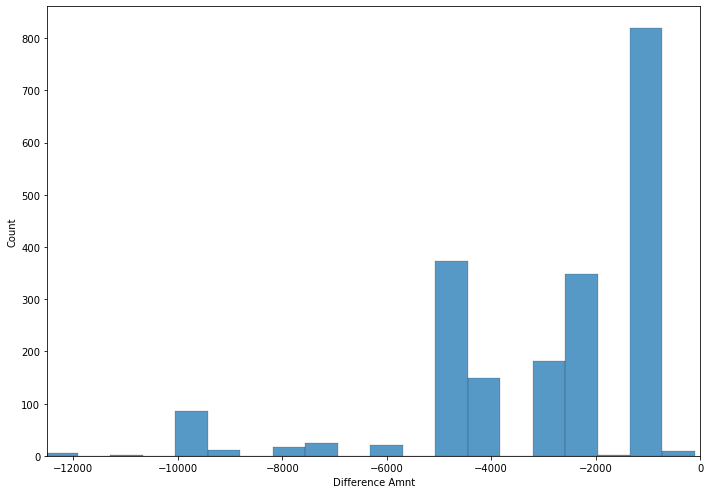

In [20]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# df[df.Difference != 0].head()
# df.loc[:, 'Difference Amnt'].describe()
# df.loc[:, 'Difference Amnt'].hist()
# plt.show()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
# sns.histplot(df, x = 'Difference Amnt', ax = ax)

# plt.xlim(-250000, 500000)
# df[df.loc[:, 'Difference Amnt'] < -100000]#[['Total Compensation', 'Base', 'Stock', 'Bonus', 'Difference Amnt']]

# plt.ylim(0, 25000)
# plt.xlim(0, 4000)

# plt.ylim(0, 75)
# plt.xlim(100000, 1000000)

#Looking at negative ones.
us[us.loc[:, 'Difference Amnt'] < 0]['Difference Amnt']
sns.histplot(us[us.loc[:, 'Difference Amnt'] < 0], x = 'Difference Amnt', ax = ax)

plt.xlim(-12500, 0)

#Based on findings reads like might be good to cutoff between -2000 and +2000

In [21]:
len(df) #29776
df = df[(df.loc[:, 'Difference Amnt'] >= -2000) & (df.loc[:, 'Difference Amnt'] <= 2000)]

In [22]:
len(df) #25607 Left

25607

In [23]:
#Normalizing companies.
comps = list(df.Company.unique())
#Fixing companies that are NaN with "Unknown"
df.loc[:, 'Company'] = np.where(df.Company.isnull(), 'Unknown', df.Company)
comps = list(df.Company.unique())
#Some companies have leading/trailing white space. And setting all to lowercase.
comps = [c.strip() for c in comps]
comps = [c.lower() for c in comps]
#sorted(list(set(comps)))

In [24]:
normalize = {
    'akamai': 'akamai technologies', 'amazon web services': 'amazon', 'apple inc.': 'apple',
    'aws': 'amazon', 'bank of america merrill lynch': 'bank of america', 'bcg digital ventures': 'bcg',
    'bloomberg lp': 'bloomberg', 'booking': 'booking.com', 'cisco meraki': 'cisco', 'cisco systems': 'cisco',
    'deloitte consulting': 'deloitte', 'epam systems': 'epam', 'epic systems': 'epic', 'expedia group': 'expedia',
    'ford motor': 'ford', 'ge digital': 'ge', 'ge healthcare': 'ge', 'gojek tech': 'gojek', 'guidewire software': 'guidewire',
    'hewlett packard enterprise': 'hp', 'hp inc': 'hp', 'intel corporation': 'intel', 'jpmorgan chase': 'jpmorgan',
    'juniper': 'juniper networks', 'mckinsey & company': 'mckinsey', 'micron technology': 'micron',
    'raytheon technologies': 'raytheon', 'samsung electronics america': 'samsung',
    'samsung research america': 'samsung', 'sony interactive entertainment': 'sony', 'verizon media': 'verizon',
    'walmart labs': 'walmart', 'zillow group': 'zillow', 'the walt disney company': 'disney',
    'new york times': 'the new york times'
}

In [25]:
#Performing same operations on dataframe.
df.loc[:, 'Company'] = df.loc[:, 'Company'].str.strip()
df.loc[:, 'Company'] = df.loc[:, 'Company'].str.lower()
#Mapping new values
df.loc[:, 'Company'] = df.loc[:, 'Company'].replace(normalize)
df.loc[:, 'Company'] = df.loc[:, 'Company'].str.title()

In [26]:
#Adding chronology column to support plotting.

chronology = df[['Month', 'Year', 'Company']].groupby(['Year', 'Month']).count().reset_index()
chronology.loc[:, 'Chronology'] = np.arange(1, len(chronology) + 1)
chronology = chronology.drop('Company', axis = 1)

In [27]:
#len(df) #Checking length to ensure no records dropped after inner join.
df = pd.merge(df, chronology, left_on = ['Year', 'Month'], right_on = ['Year', 'Month'])
#Len is same.
#len(df)

In [65]:
# df.to_excel(r'10_11_20_prepped.xlsx', index = False)